# Churn – Abandon Client Télécom

Auteurs: Julien Billeter et Michael Strefeler

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Prétraitment des données

In [2]:
data = pd.read_csv('data/Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
data['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [5]:
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"{col}: {data[col].unique()}")

customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


In [6]:
description = pd.read_csv('data/Names.csv', delimiter=';', header=None)
description

,0,1
0,customerID,Customer ID
1,gender,Whether the customer is a male or a female
2,SeniorCitizen,Whether the customer is a senior citizen or no...
3,Partner,Whether the customer has a partner or not (Yes...
4,Dependents,Whether the customer has dependents or not (Ye...
5,Tenure,Number of months the customer has stayed with ...
6,PhoneService,Whether the customer has a phone service or no...
7,MultipleLines,Whether the customer has multiple lines or not...
8,InternetService,"Customer's internet service provider (DSL, Fib..."
9,OnlineSecurity,Whether the customer has online security or no...


In [7]:
data.drop(columns=['customerID'], inplace=True)

In [8]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

yes_no_columns = [
    'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'
]

for col in yes_no_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# One-hot encoding for multi-category columns (including 3-way columns like InternetService)
multi_category_columns = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
    'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
    'StreamingMovies', 'Contract', 'PaymentMethod'
]

data = pd.get_dummies(data, columns=multi_category_columns, drop_first=True)

# Final split into features and target
X = data.drop(columns=['Churn'])
y = data['Churn']

In [9]:
X.shape

(7043, 30)

In [10]:
# Columns to scale
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = StandardScaler()
X[columns_to_scale] = scaler.fit_transform(X[columns_to_scale])
X = X.dropna()
y = y.loc[X.index]

## Exploration des données

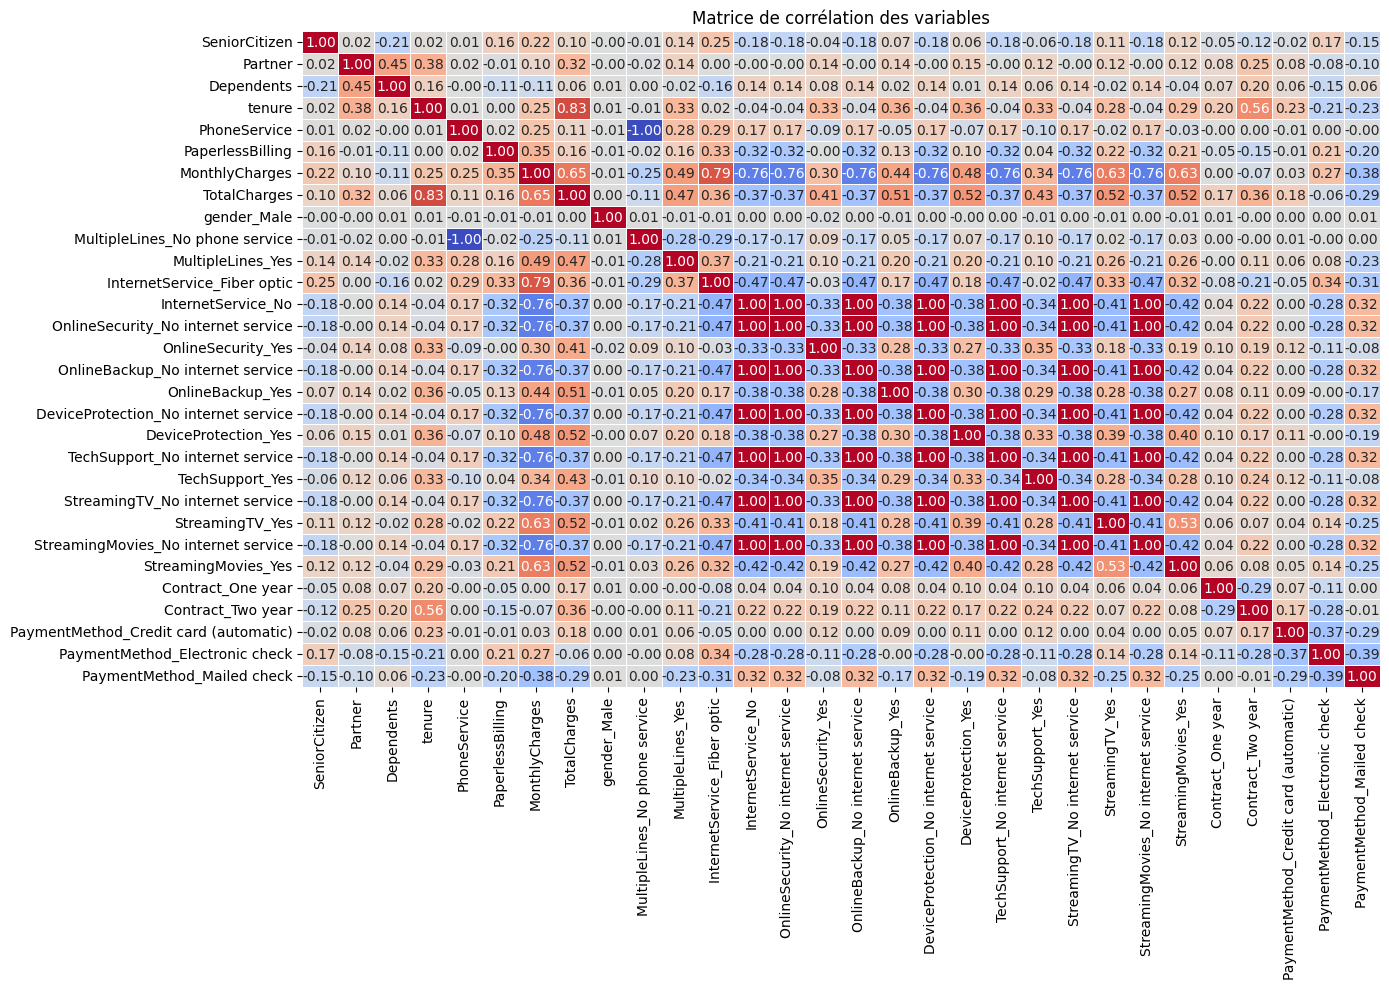

In [11]:
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar=False)
plt.title('Matrice de corrélation des variables')
plt.tight_layout()
plt.show()

## Sélection des attributs

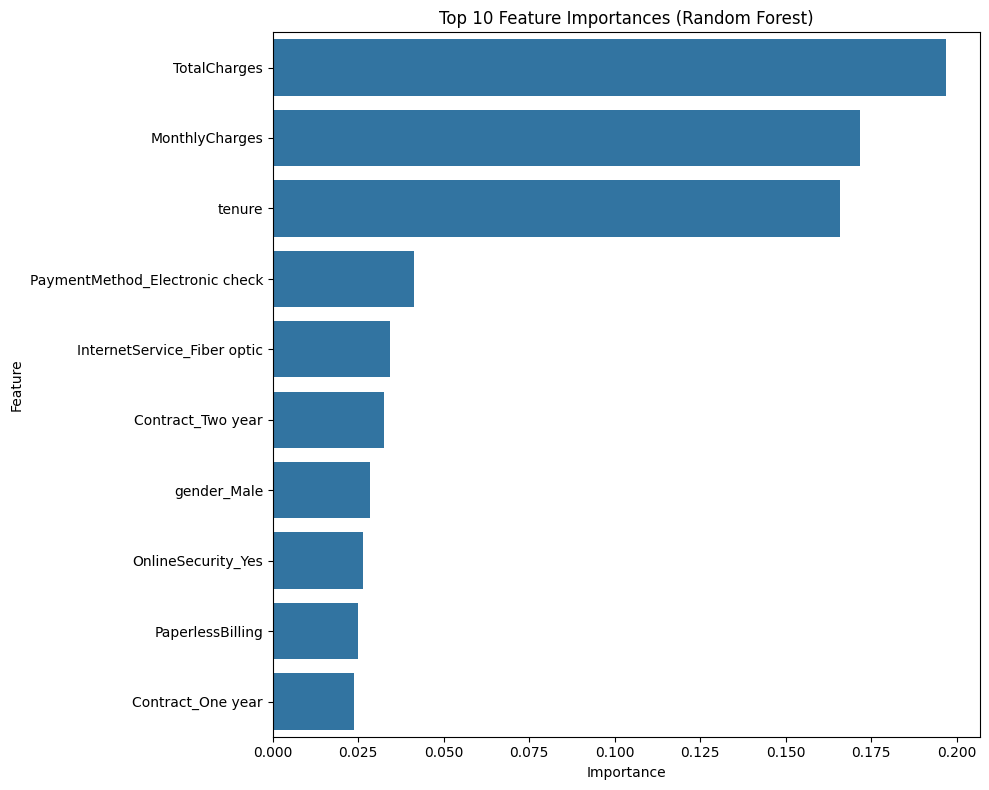

In [12]:
# Train a Random Forest on your data
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot top features
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

In [13]:
top_10_features = feat_imp_df['Feature'].head(10).tolist()
X_top10 = X[top_10_features]

## Explications ante-hoc

In [14]:
# Séparation des données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_top10, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
def evaluate_model(y_test, y_pred):
    # Évaluation
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Précision: {precision_score(y_test, y_pred):.2f}")
    print(f"F1-score: {f1_score(y_test, y_pred):.2f}")
    print("\nRapport de classification :")
    print(classification_report(y_test, y_pred, target_names=["Stay", "Leave"]))

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    etiquettes = ['Stay', 'Leave']
    df_cm = pd.DataFrame(cm, index=etiquettes, columns=etiquettes)

    plt.figure(figsize=(6, 5))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Matrice de confusion')
    plt.ylabel('Ground truth')
    plt.xlabel('Predictions')
    plt.tight_layout()
    plt.show()

### Decison Tree Classifier

Accuracy: 0.72
Précision: 0.48
F1-score: 0.47

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.81      0.82      0.81      1033
       Leave       0.48      0.46      0.47       374

    accuracy                           0.72      1407
   macro avg       0.64      0.64      0.64      1407
weighted avg       0.72      0.72      0.72      1407



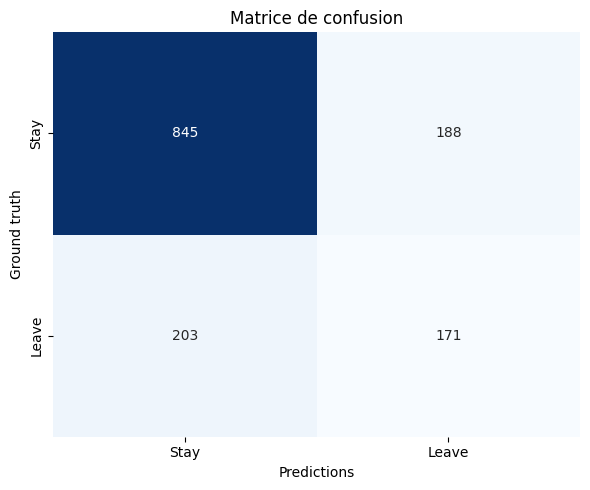

In [16]:
# Entraînement du modèle
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

# Prédictions
y_pred = tree.predict(X_test)

evaluate_model(y_test, y_pred)

### Random Forest Classifier

Accuracy: 0.78
Précision: 0.59
F1-score: 0.55

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.83      0.87      0.85      1033
       Leave       0.59      0.52      0.55       374

    accuracy                           0.78      1407
   macro avg       0.71      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



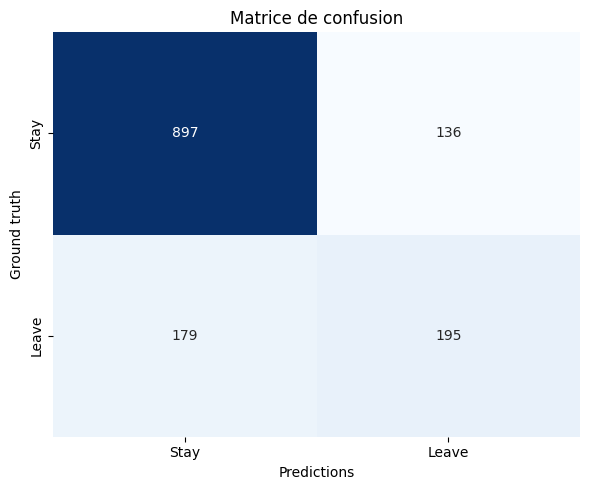

In [17]:
# Entraînement du modèle
clf = RandomForestClassifier(n_estimators=25, random_state=42)
clf.fit(X_train, y_train)

# Prédictions
y_pred = clf.predict(X_test)

evaluate_model(y_test, y_pred)

### Regression logistique

Accuracy: 0.79
Précision: 0.62
F1-score: 0.56

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.83      0.89      0.86      1033
       Leave       0.62      0.51      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



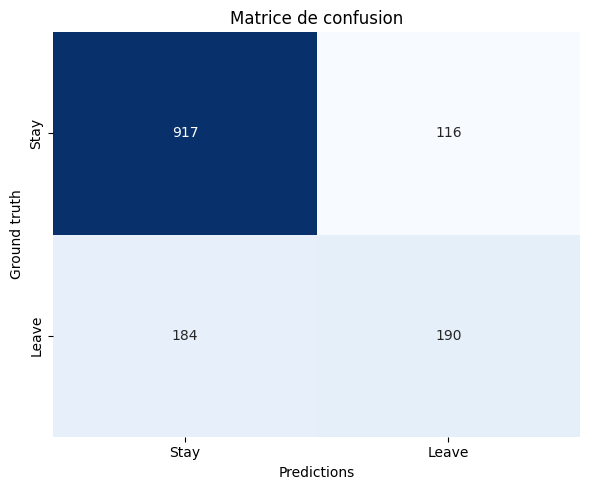

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

evaluate_model(y_test, y_pred)

## Explications post-hoc

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [20]:
import torch

# Convert pandas DataFrame/Series to torch tensors
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

# Now convert to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)  # Make it (N,1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [21]:
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [22]:
class ChurnNet(nn.Module):
    def __init__(self, input_dim):
        super(ChurnNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
model = ChurnNet(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [24]:
epochs = 30

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} — Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1/30 — Loss: 0.5121
Epoch 2/30 — Loss: 0.4353
Epoch 3/30 — Loss: 0.4273
Epoch 4/30 — Loss: 0.4238
Epoch 5/30 — Loss: 0.4218
Epoch 6/30 — Loss: 0.4206
Epoch 7/30 — Loss: 0.4194
Epoch 8/30 — Loss: 0.4191
Epoch 9/30 — Loss: 0.4177
Epoch 10/30 — Loss: 0.4181
Epoch 11/30 — Loss: 0.4181
Epoch 12/30 — Loss: 0.4175
Epoch 13/30 — Loss: 0.4169
Epoch 14/30 — Loss: 0.4157
Epoch 15/30 — Loss: 0.4159
Epoch 16/30 — Loss: 0.4147
Epoch 17/30 — Loss: 0.4147
Epoch 18/30 — Loss: 0.4148
Epoch 19/30 — Loss: 0.4141
Epoch 20/30 — Loss: 0.4147
Epoch 21/30 — Loss: 0.4142
Epoch 22/30 — Loss: 0.4137
Epoch 23/30 — Loss: 0.4133
Epoch 24/30 — Loss: 0.4146
Epoch 25/30 — Loss: 0.4123
Epoch 26/30 — Loss: 0.4130
Epoch 27/30 — Loss: 0.4121
Epoch 28/30 — Loss: 0.4124
Epoch 29/30 — Loss: 0.4110
Epoch 30/30 — Loss: 0.4117


Accuracy: 0.79
Précision: 0.63
F1-score: 0.57

Rapport de classification :
              precision    recall  f1-score   support

        Stay       0.84      0.89      0.86      1033
       Leave       0.63      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



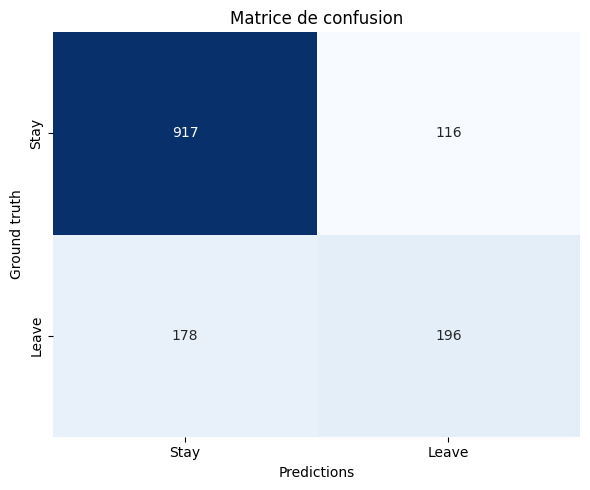

In [25]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_tensor).squeeze().numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = y_test_tensor.squeeze().numpy()

evaluate_model(y_true, y_pred)